In [1]:
from vtkmodules.vtkCommonCore import vtkDenseArray_IxE
from flame_analysis_model import *
from mpi4py import MPI
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib as mpl
plt.rcParams.update({
    "figure.dpi": 150,   # higher resolution
    "font.size": 11,     # larger fonts
})

In [2]:

time_step = 212
phi = 0.40
lat_size = 100
T_ref = 300
p_ref = 5e05
isolevels = [2.5, 3, 3.5, 4, 4.5, 4.7]
n_isolevels = len(isolevels)

folder_name = f"data/phi{phi:.2f}/h400x{lat_size}_ref"
file_name = "premix"

In [3]:
rebuild_dataset = False
if rebuild_dataset:

    comm = MPI.COMM_WORLD
    rank = comm.rank

    # 2) Load dataset
    scalars = [
        'H2','O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
        'curvature', 'stretch_rate', 'disp_speed_density_weighted',
        'abs_flame_prop_vel_normal', 'flow_velocity_normal',
        'flow_velocity_tangential', 'tangential_strain_rate',
        'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
        'vorticity'
    ]

    ds = SEMDataset(file_name=file_name, folder_name= folder_name,time_step= time_step, comm=MPI.COMM_WORLD, scalar_names=scalars)
    df = ds.create_dataframe(
        compute_vel_jacobian= False,
        compute_vel_hessian= False,
        compute_reaction_rates= True,
        cantera_inputs = ["../chemical_mech/BurkeH2.yaml", None, phi, T_ref, p_ref]
    )
    fig, ax = plt.subplots(figsize=(8, 10), dpi=150)
    for c in isolevels:
        # Extract flame front
        front = ds.extract_flame_front_unstruct(
            c_level=c,
        )
        # Save to csv
        front.to_csv(f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref/extracted_flame_front_{time_step}_iso_{c}.csv", index=False)
        # Plot
        ax.scatter(
            front["x"],
            front["y"],
            s=0.01,
            alpha=1,
            label=fr"$T={c}$"
        )

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Temperature along flame fronts (phi={phi:.2f}, timestep={time_step})")
    ax.legend(markerscale=2, fontsize=8)
    ax.grid(True)

    plt.show()


phi0.40/h400x100_ref
Isolevels: [2.5, 3, 3.5, 4, 4.5, 4.7]
Number of clusters 10
Feature setting: reaction


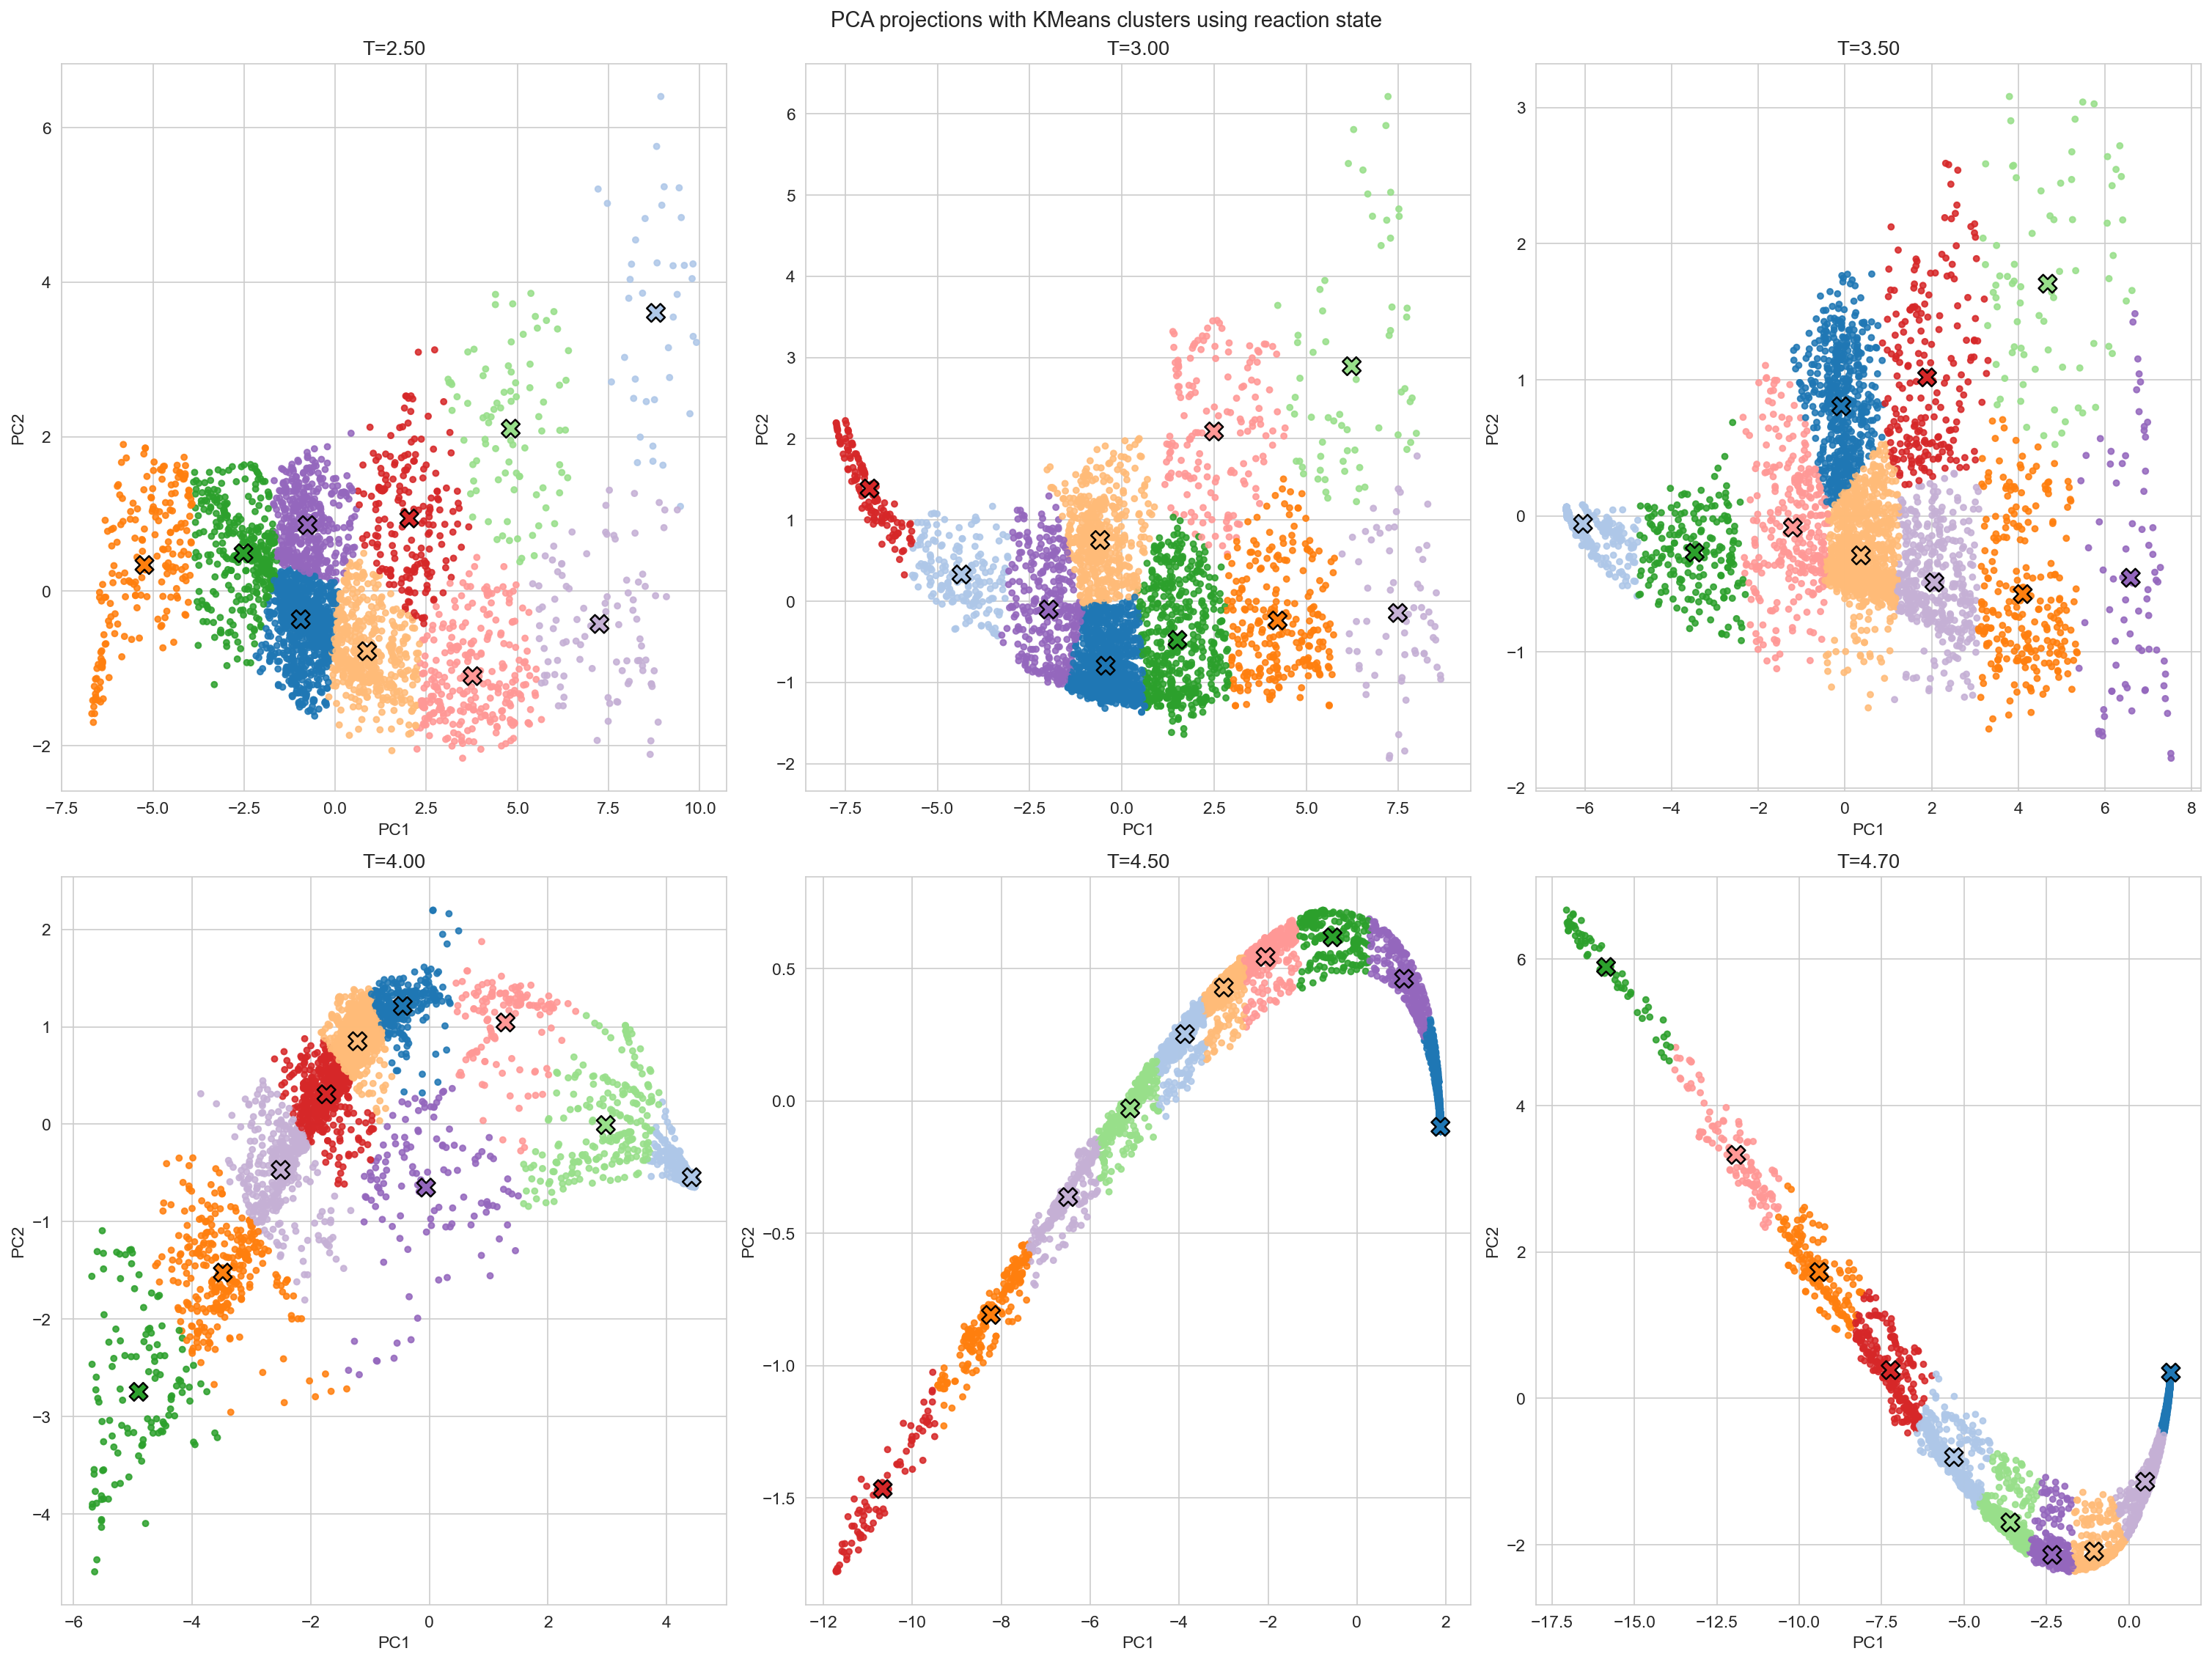

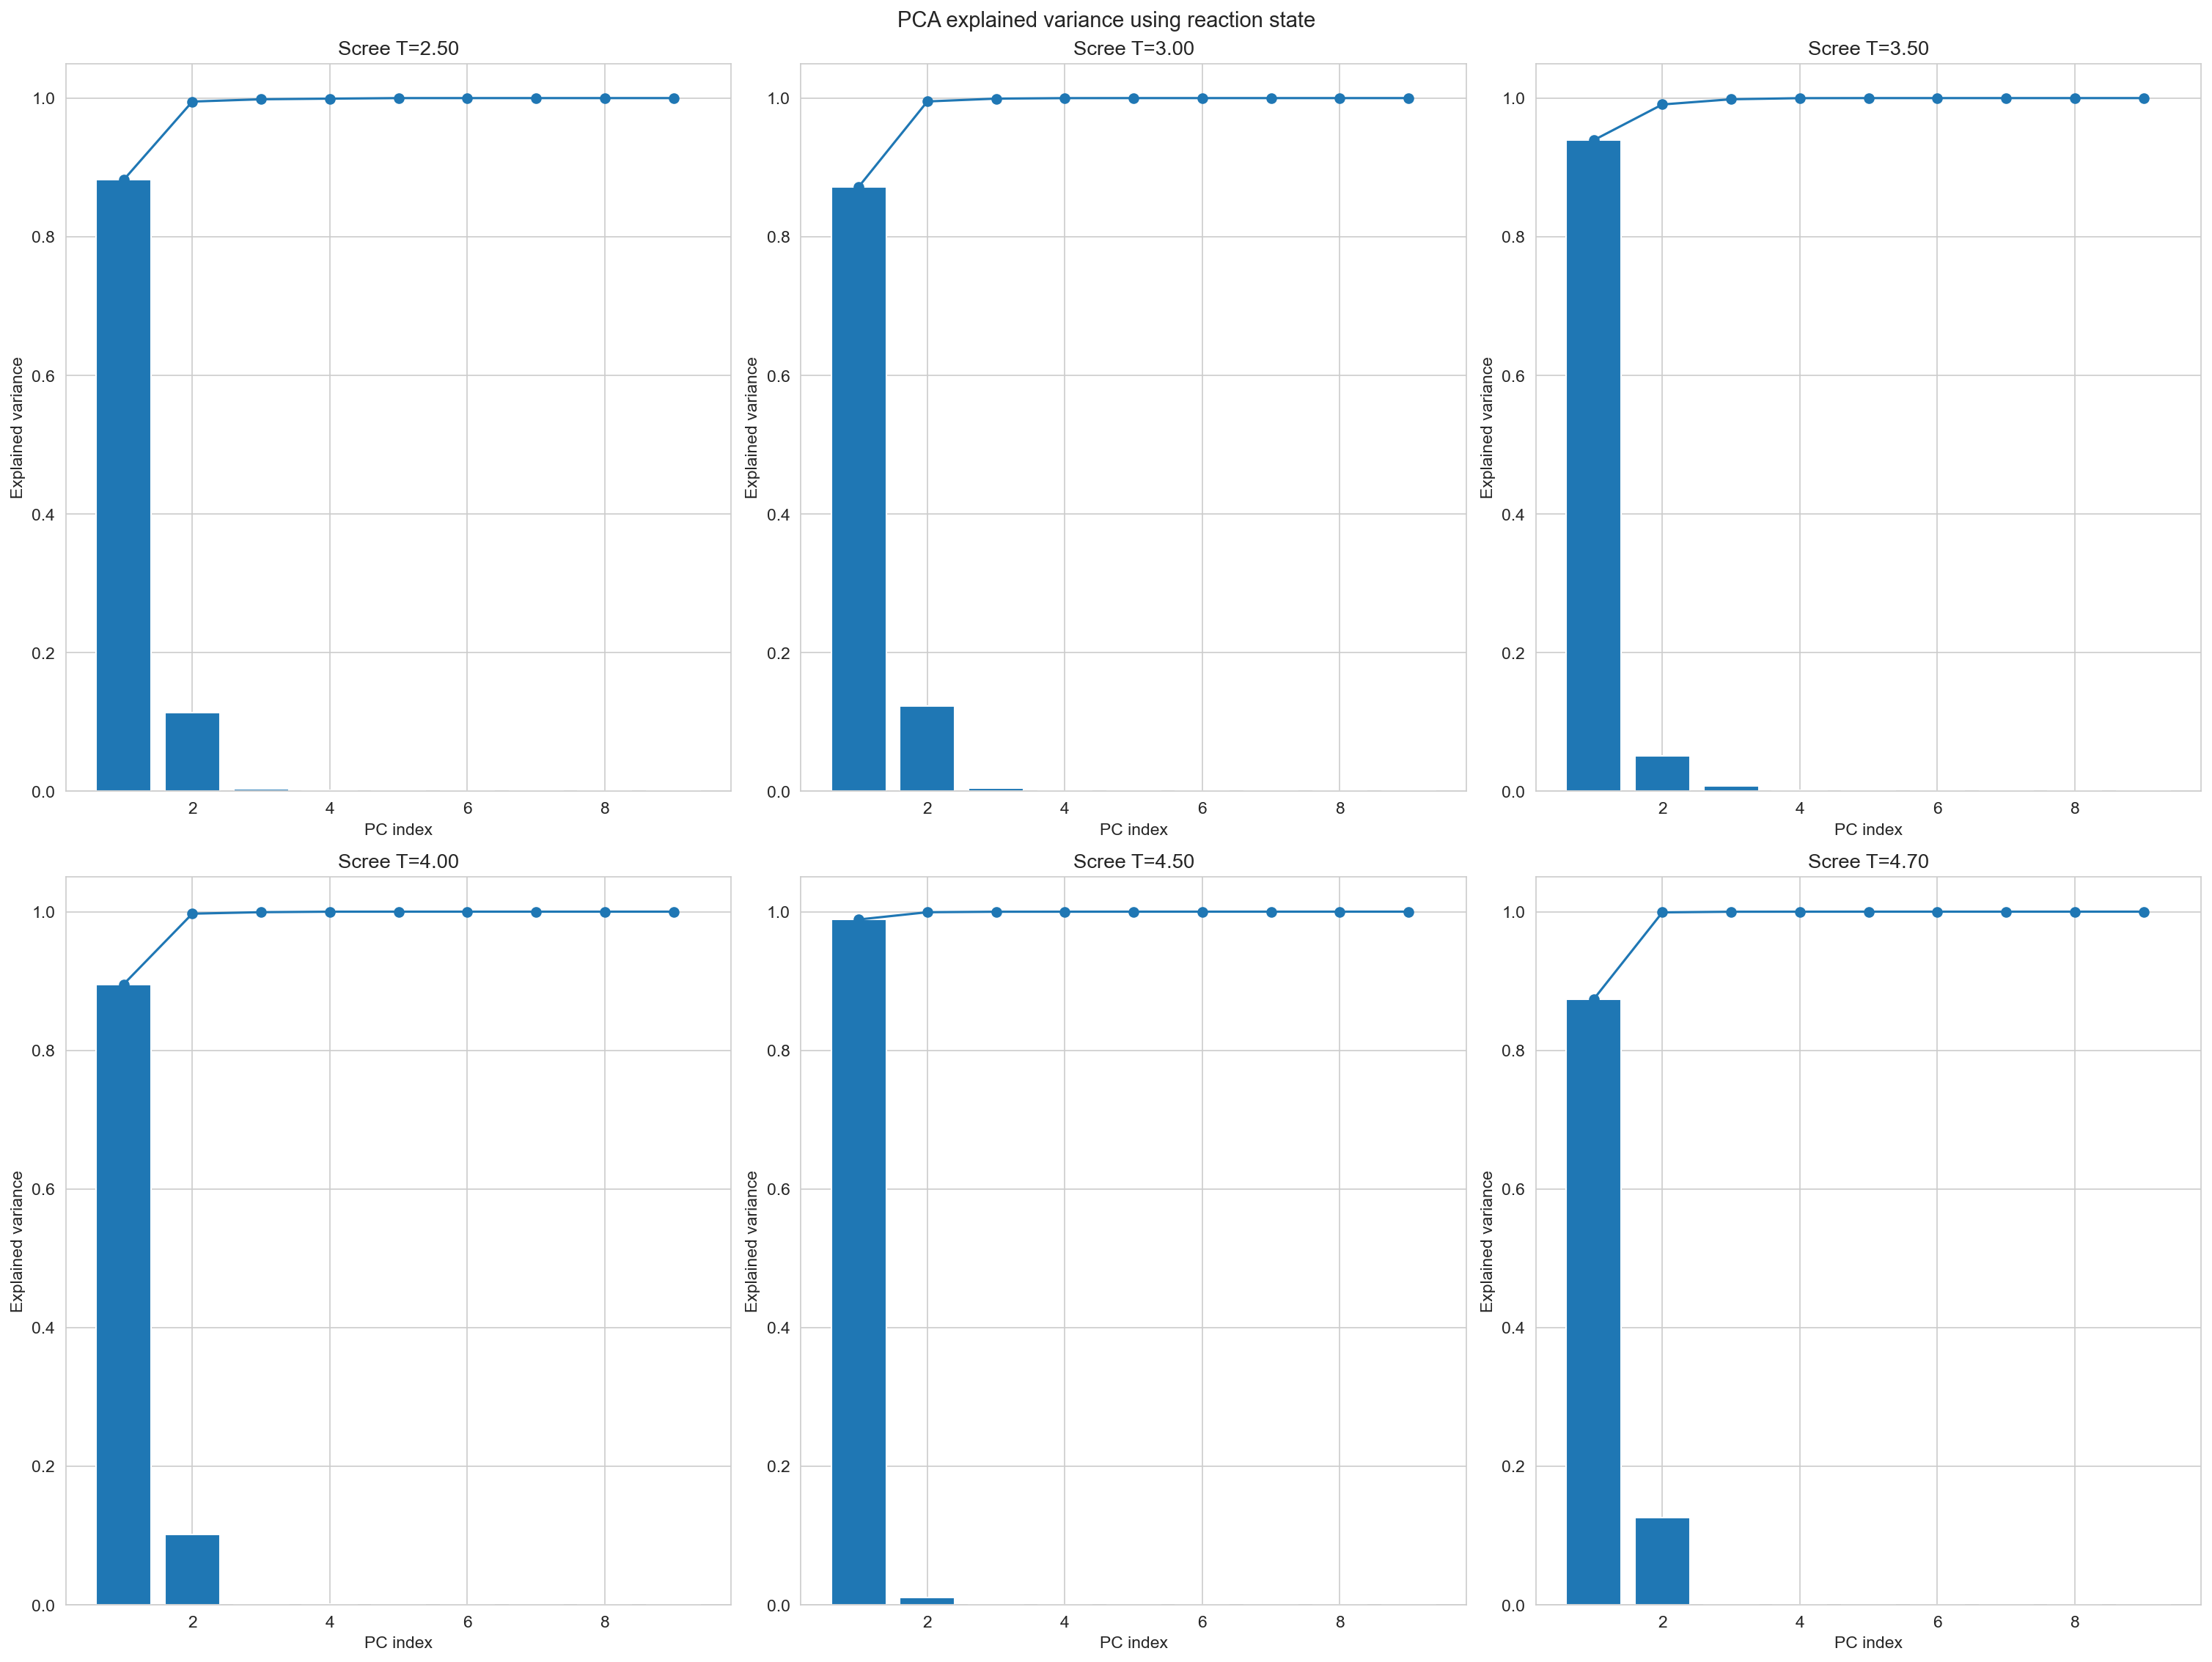

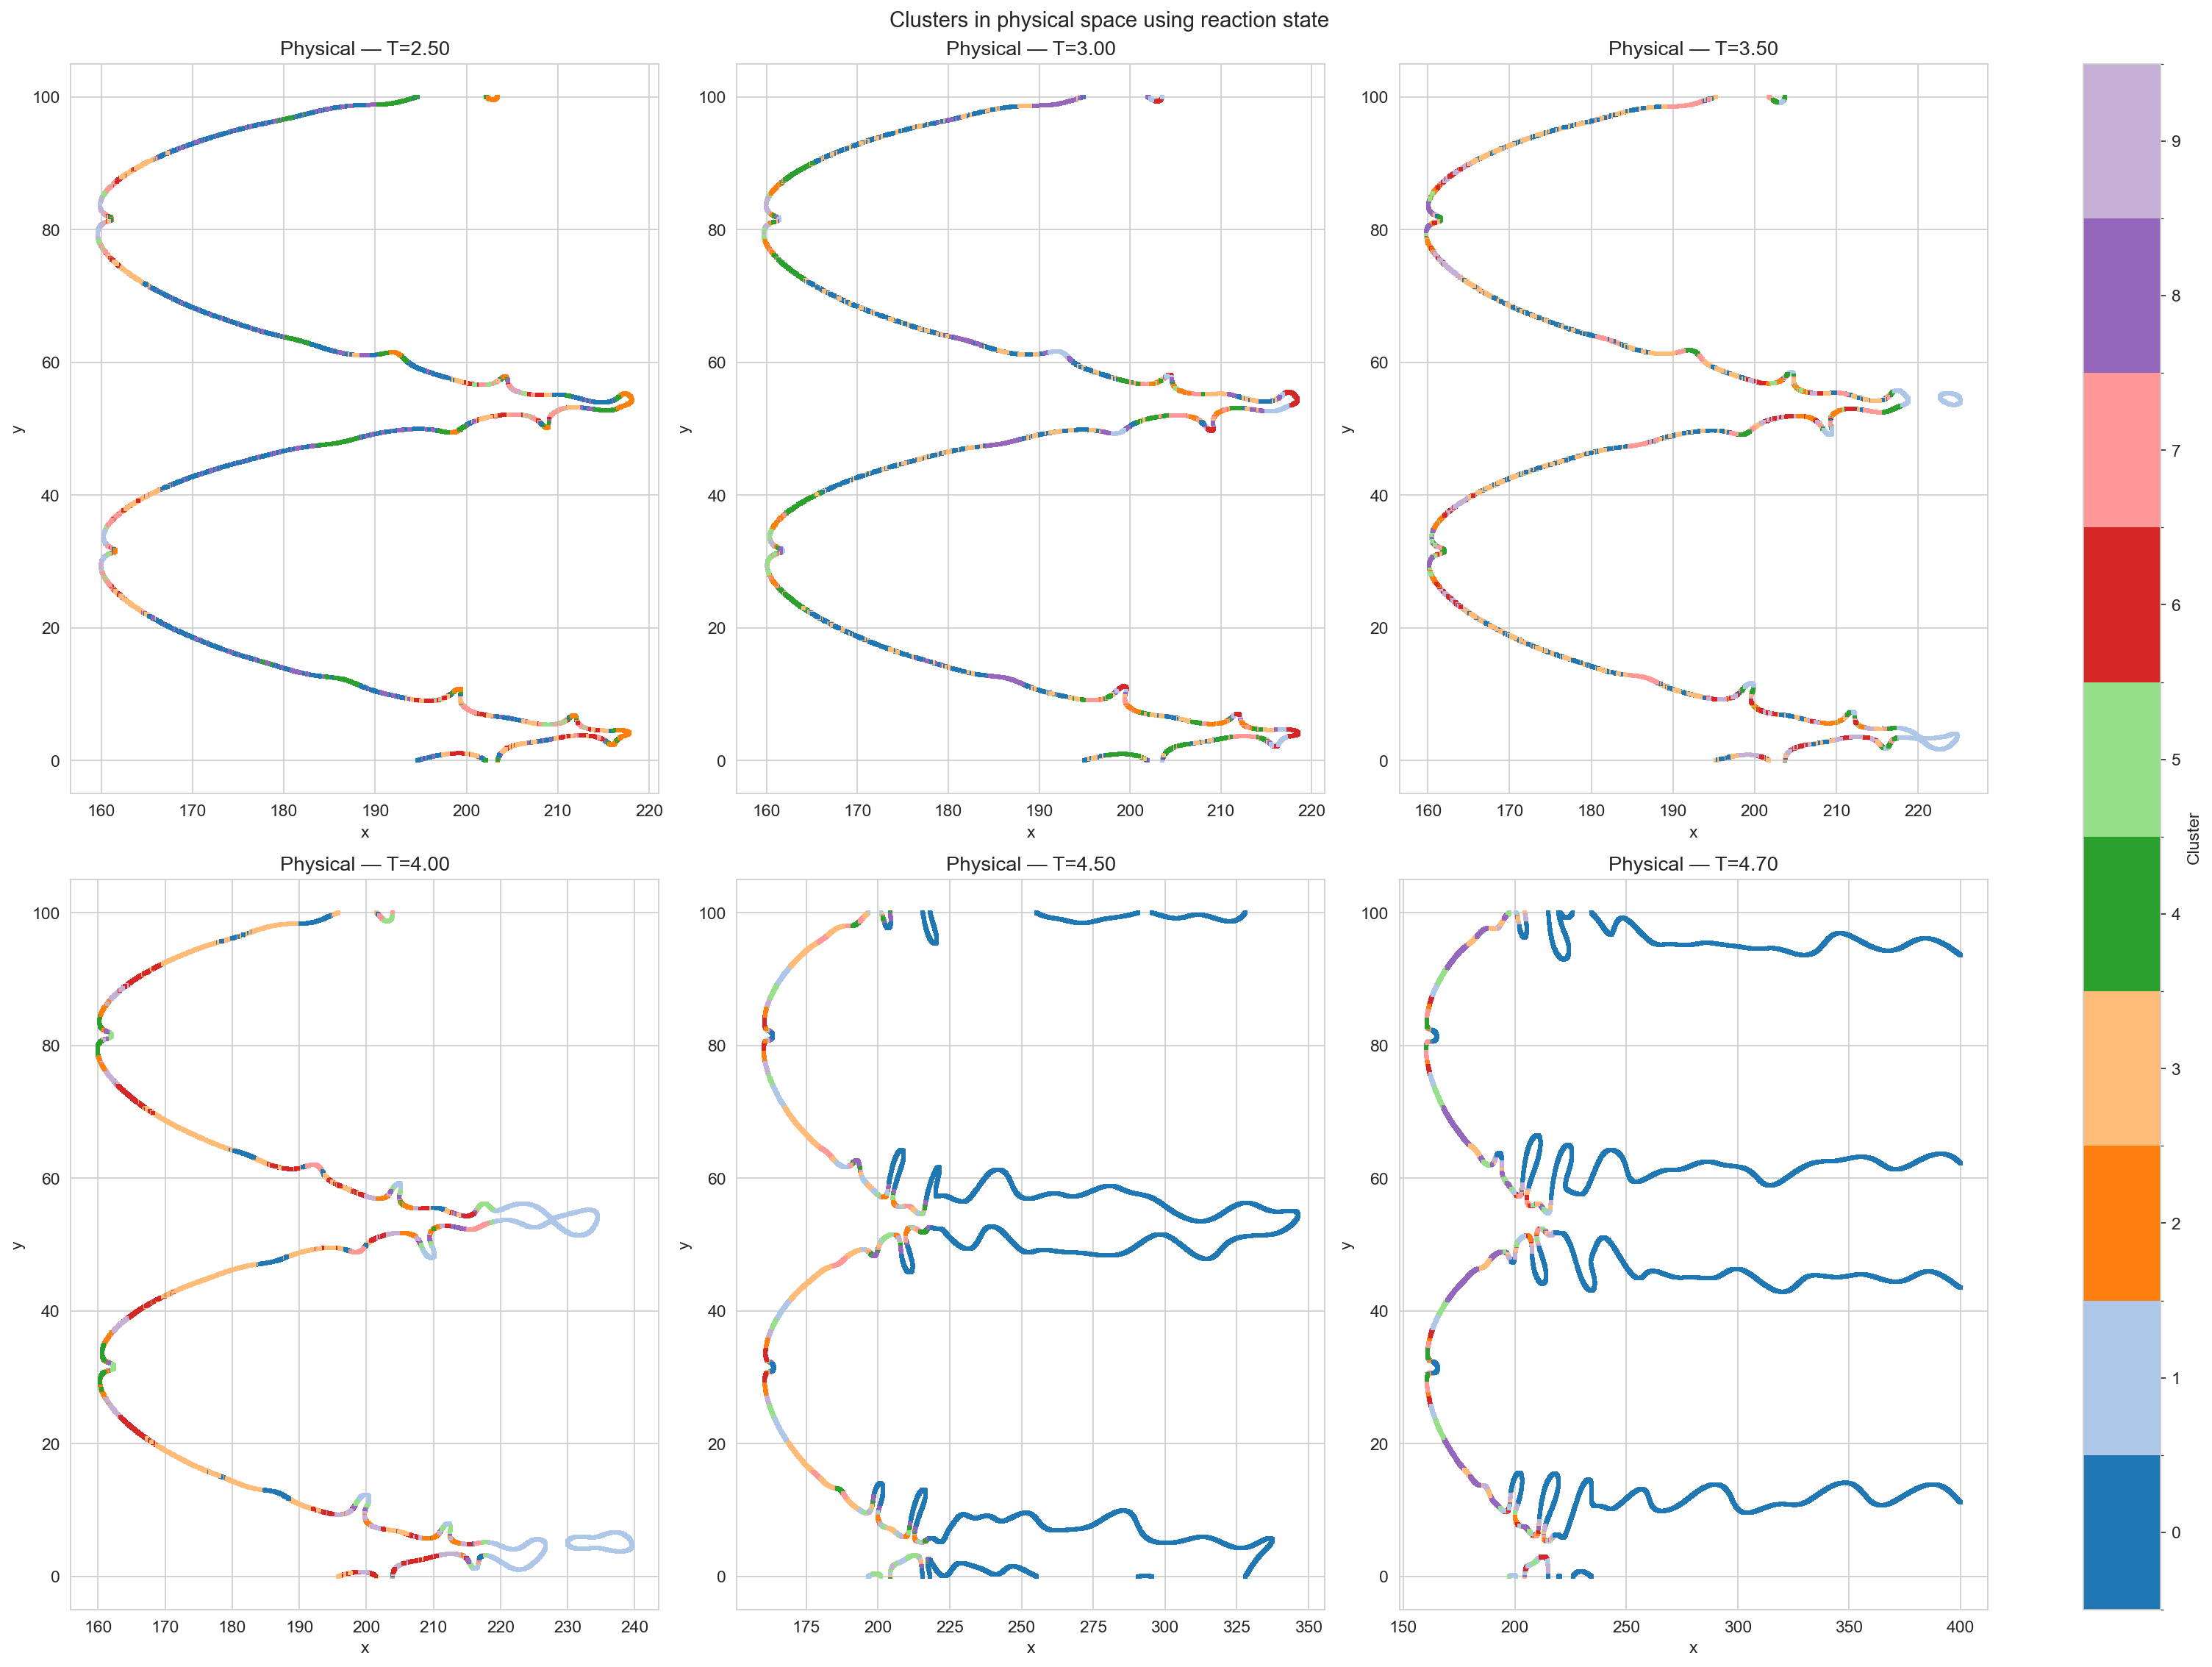

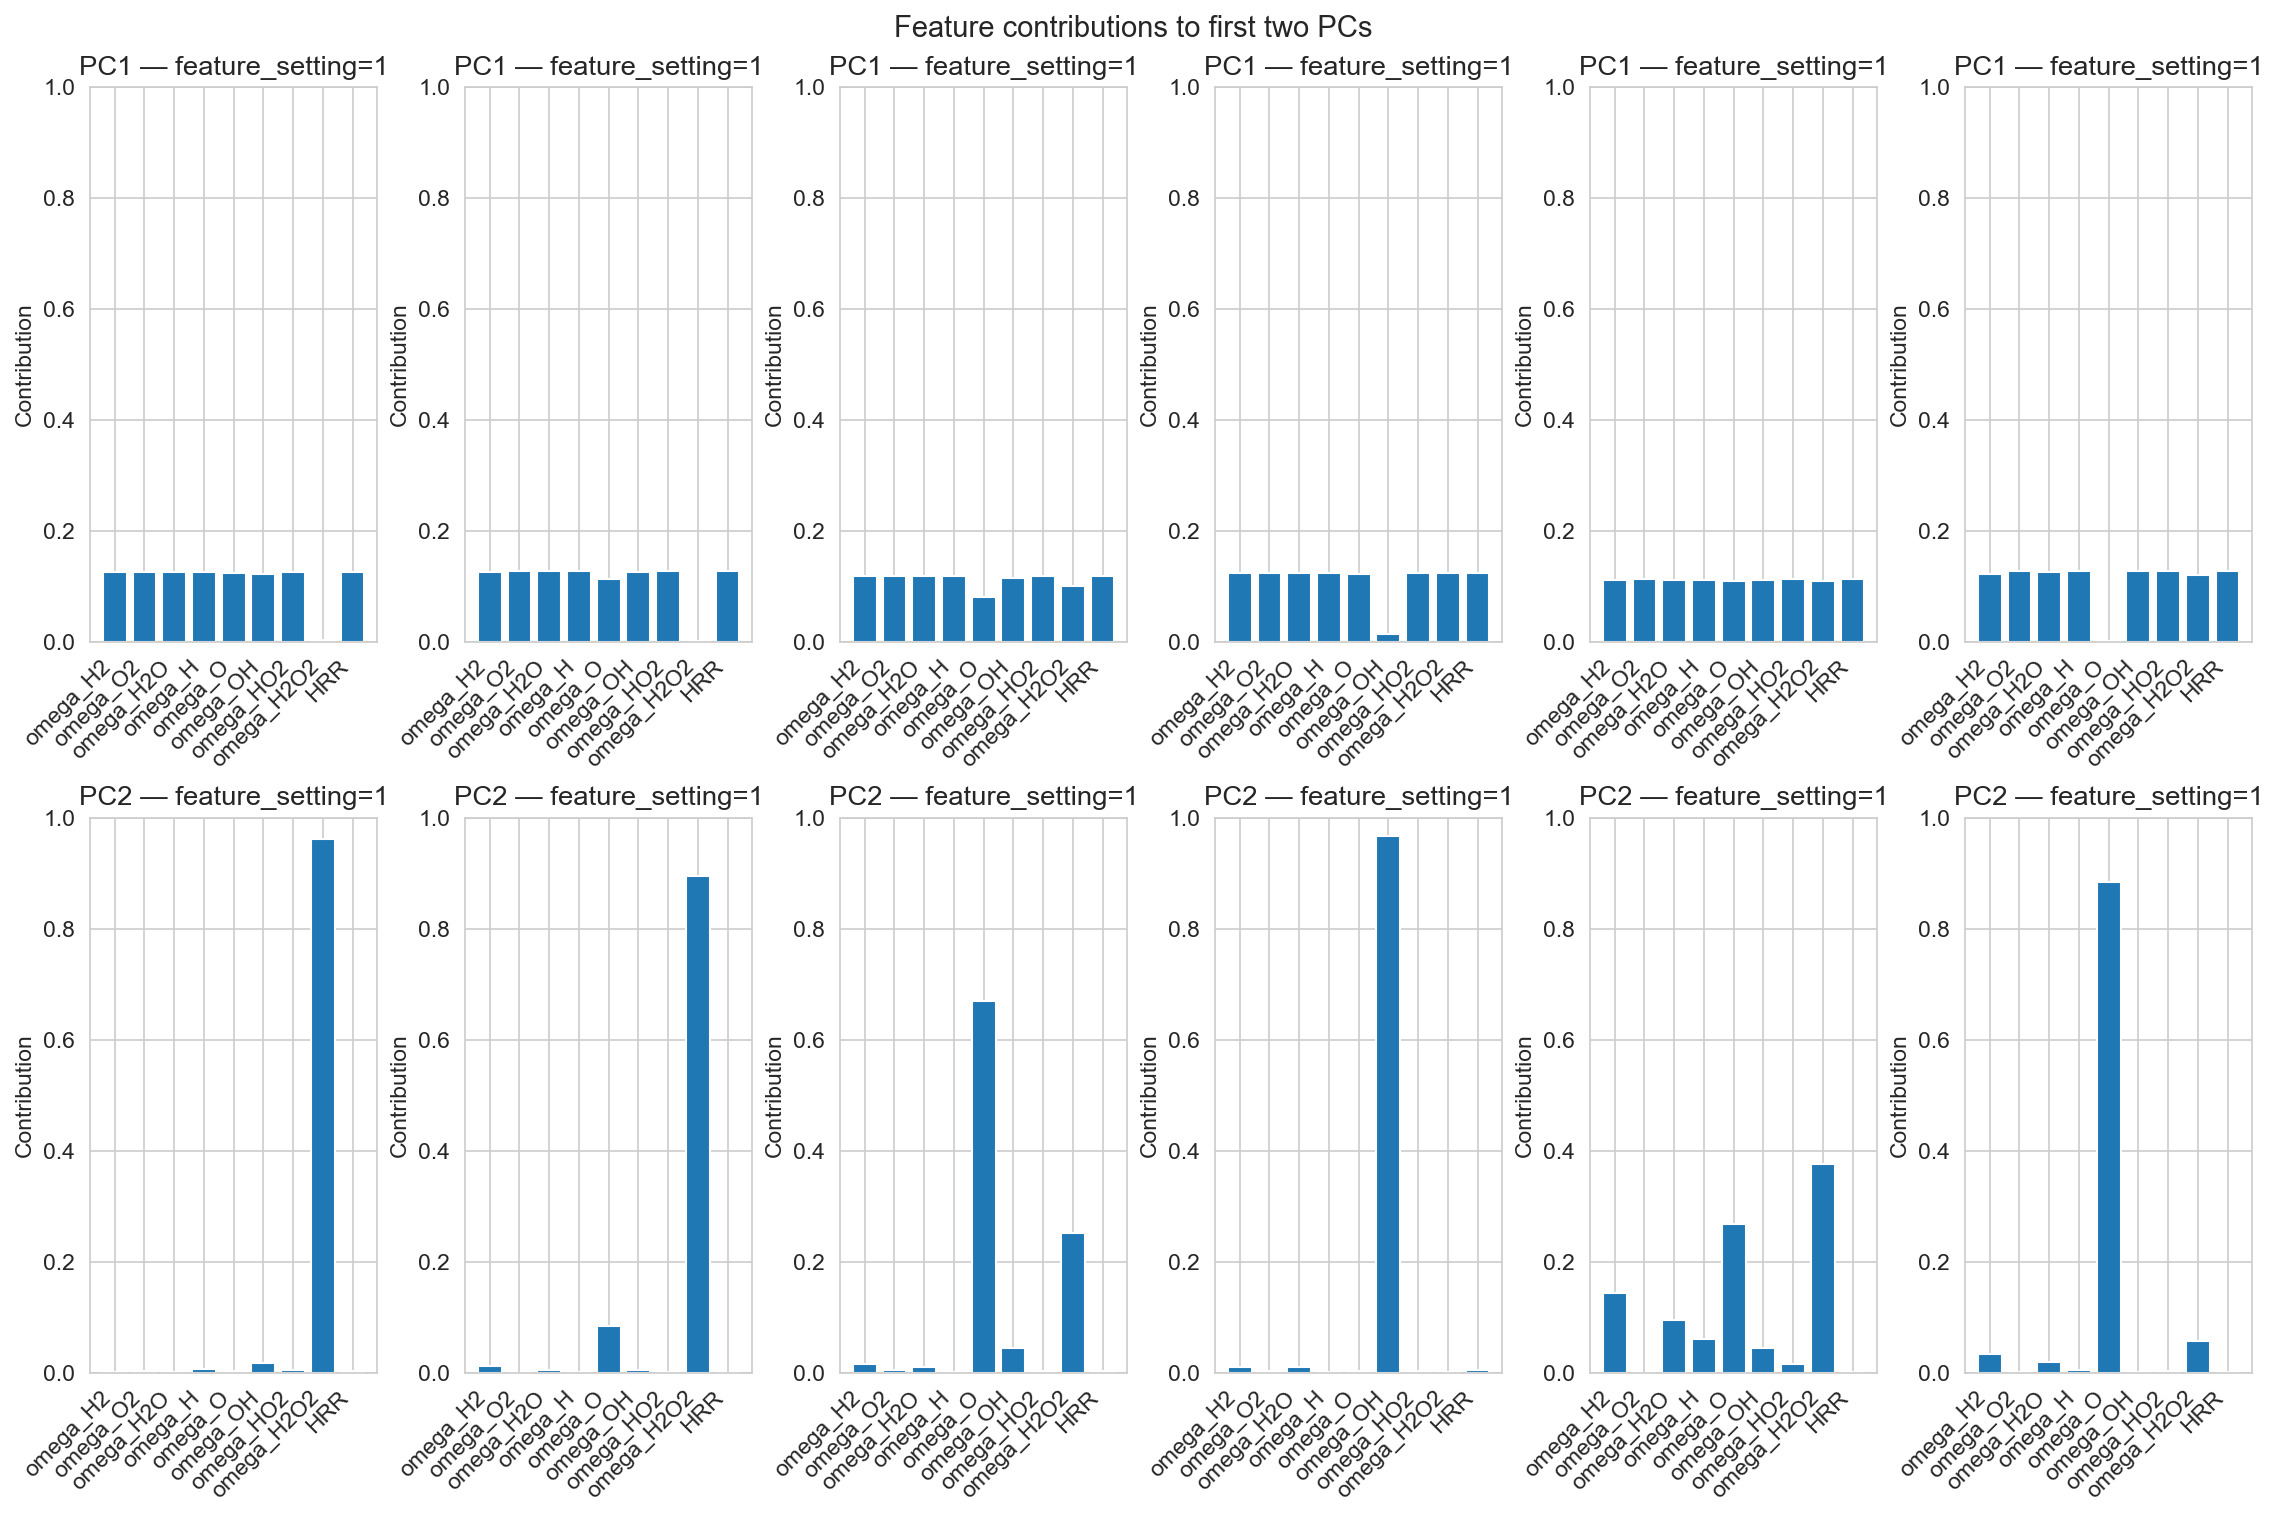

In [4]:
# ============================================================
# STORAGE DICTIONARY FOR LATER USE
# ============================================================
all_cluster_results = {}   # <-- NEW: store everything here
# Keys will be isolevels: c_val

feature_setting = 1
n_clusters = 10

if feature_setting:
    plot_title = "reaction"
else:
    plot_title = "state"

print(f"phi{phi:.2f}/h400x{lat_size}_ref")
print(f"Isolevels: {isolevels}")
print(f"Number of clusters {n_clusters}")
print(f"Feature setting: {plot_title}")


fig_pca,   axs_pca   = plt.subplots(2, 3, figsize=(20, 15), constrained_layout=True)
fig_scree, axs_scree = plt.subplots(2, 3, figsize=(20, 15), constrained_layout=True)
fig_phys,  axs_phys  = plt.subplots(2, 3, figsize=(20, 15), constrained_layout=True)
fig_load, axs_load   = plt.subplots(2, 6, figsize=(15, 10), constrained_layout=True)

base_cmap = mpl.colormaps['tab20']
colors = [base_cmap(i) for i in range(n_clusters)]
cmap_clusters = ListedColormap(colors)
bounds = np.arange(-0.5, n_clusters + 0.5, 1)
norm_clusters = BoundaryNorm(bounds, cmap_clusters.N)

# --------------------------------------------------------------
# Select features
# --------------------------------------------------------------
if feature_setting == 0:
    features = ['H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2']
else:
    features = [
        'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
        'omega_HO2', 'omega_H2O2', 'HRR'
    ]

# --------------------------------------------------------------
# Loop over isocontours
# --------------------------------------------------------------
for c_idx, c_val in enumerate(isolevels):

    row = c_idx // 3
    col = c_idx % 3

    front = pd.read_csv(
        f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref/"
        f"extracted_flame_front_{time_step}_iso_{c_val}.csv"
    )

    X_raw = front[features].to_numpy()

    pipe = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        KMeans(n_clusters=n_clusters, init="k-means++", n_init=20,
               max_iter=300, random_state=0)
    )
    labels = pipe.fit_predict(X_raw)

    scaler = pipe.named_steps["standardscaler"]
    centroids_scaled   = pipe.named_steps["kmeans"].cluster_centers_
    centroids_unscaled = scaler.inverse_transform(centroids_scaled)
    X_scaled           = scaler.transform(X_raw)

    # ----------------------------------------------------------
    # PCA
    # ----------------------------------------------------------
    pca = PCA(n_components=None, random_state=0)
    X2d         = pca.fit_transform(X_scaled)
    centroids2d = pca.transform(centroids_scaled)

    loadings = pca.components_[:2, :]
    contrib = loadings**2
    contrib = contrib / contrib.sum(axis=1, keepdims=True)

    # ----------------------------------------------------------
    # STORE RESULTS for LATER USE  (NEW)
    # ----------------------------------------------------------
    all_cluster_results[c_val] = {
        "front": front,                   # original dataframe
        "labels": labels,                 # cluster IDs
        "X_raw": X_raw,                   # unscaled feature matrix
        "X_scaled": X_scaled,             # scaled feature matrix
        "centroids_scaled": centroids_scaled,
        "centroids_unscaled": centroids_unscaled,
        "X2d": X2d,                       # PCA projection
        "centroids2d": centroids2d,
        "scaler": scaler,
        "pca": pca,
        "pipe": pipe,
        "features": features,
        "contrib": contrib,
    }

    # ----------------------------------------------------------
    # ORIGINAL PLOTTING CODE (unchanged)
    # ----------------------------------------------------------

    # PCA plot
    axp = axs_pca[row, col]
    sc_pca = axp.scatter(
        X2d[:, 0], X2d[:, 1],
        c=labels, cmap=cmap_clusters, norm=norm_clusters,
        s=14, alpha=0.85
    )
    axp.scatter(
        centroids2d[:, 0], centroids2d[:, 1],
        c=np.arange(n_clusters), cmap=cmap_clusters, norm=norm_clusters,
        s=140, marker="X", edgecolor="k", linewidths=1.2
    )
    axp.set_title(f"T={c_val:.2f}")
    axp.set_xlabel("PC1")
    axp.set_ylabel("PC2")

    # Scree
    evr = pca.explained_variance_ratio_
    cum_evr = np.cumsum(evr)
    axs_scr = axs_scree[row, col]
    idx = np.arange(1, len(evr) + 1)
    axs_scr.bar(idx, evr)
    axs_scr.plot(idx, cum_evr, marker="o")
    axs_scr.set_title(f"Scree T={c_val:.2f}")
    axs_scr.set_xlabel("PC index")
    axs_scr.set_ylabel("Explained variance")

    # Feature contributions
    for pc_idx, pc_name in enumerate(["PC1", "PC2"]):
        ax_l = axs_load[pc_idx, c_idx]
        ax_l.bar(np.arange(len(features)), contrib[pc_idx])
        ax_l.set_xticks(np.arange(len(features)))
        ax_l.set_xticklabels(features, rotation=45, ha="right")
        ax_l.set_ylabel("Contribution")
        ax_l.set_ylim(0, 1)
        ax_l.set_title(f"{pc_name} — feature_setting={feature_setting}")

    # Physical space plot
    ax_phys = axs_phys[row, col]
    ax_phys.scatter(
        front['x'], front['y'],
        c=labels,
        cmap=cmap_clusters, norm=norm_clusters,
        s=8, marker='s', linewidths=0
    )
    ax_phys.set_xlabel("x")
    ax_phys.set_ylabel("y")
    ax_phys.set_title(f"Physical — T={c_val:.2f}")

# Shared colourbar
cb = fig_phys.colorbar(
    mpl.cm.ScalarMappable(norm=norm_clusters, cmap=cmap_clusters),
    ax=axs_phys.ravel().tolist(),
    ticks=np.arange(n_clusters)
)
cb.set_label("Cluster")

fig_pca.suptitle(f"PCA projections with KMeans clusters using {plot_title} state", fontsize=14)
fig_scree.suptitle(f"PCA explained variance using {plot_title} state", fontsize=14)
fig_phys.suptitle(f"Clusters in physical space using {plot_title} state", fontsize=14)
fig_load.suptitle("Feature contributions to first two PCs", fontsize=14)

plt.show()



## Sd vs Stretch, conditioned on different clusters and isotherms

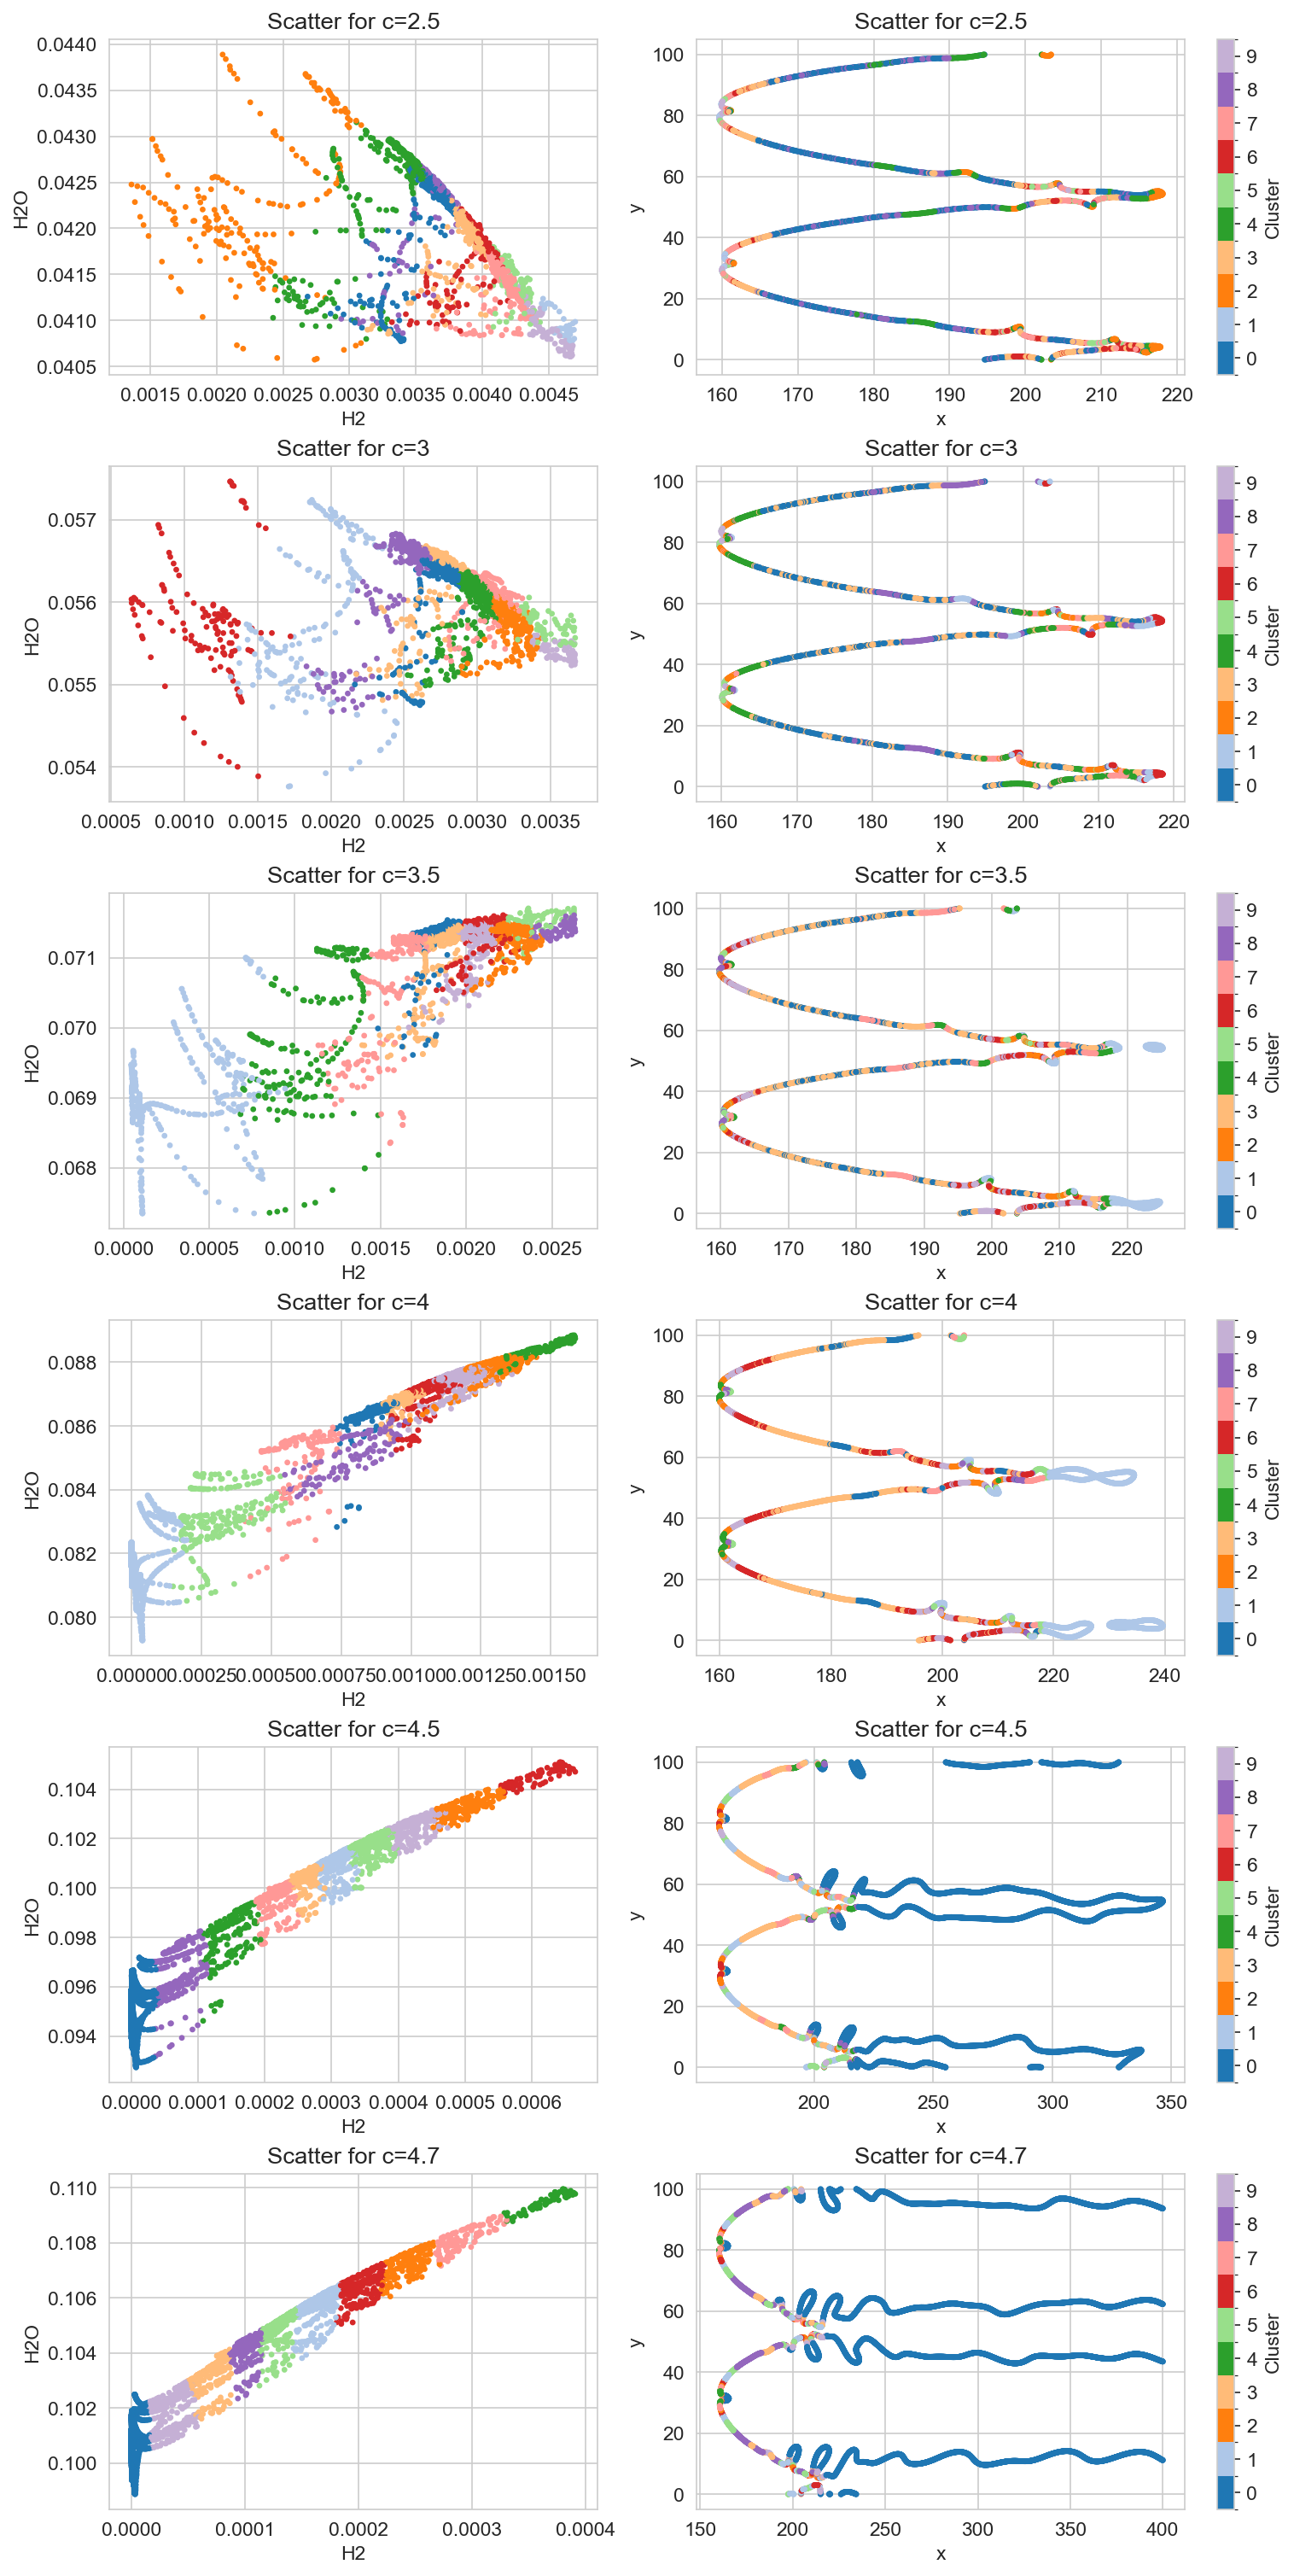

In [5]:
var_x = "H2"
var_y = "H2O"
fig, axs = plt.subplots(n_isolevels, 2, figsize=(10, 20), constrained_layout=True)

for idx, c_val in enumerate(isolevels):
    res = all_cluster_results[c_val]

    front  = res["front"]
    labels = res["labels"]

    # choose the axis for this isolevel
    ax = axs[idx, 0]   # left column for scatter
    sc = ax.scatter(
        front[var_x], front[var_y],
        c=labels, cmap=cmap_clusters, norm=norm_clusters, s=5
    )
    ax.set_xlabel(var_x)
    ax.set_ylabel(var_y)
    ax.set_title(f"Scatter for c={c_val}")

        # choose the axis for this isolevel
    ax = axs[idx, 1]   # left column for scatter
    sc = ax.scatter(
        front["x"], front["y"],
        c=labels, cmap=cmap_clusters, norm=norm_clusters, s=5
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Scatter for c={c_val}")

    # Add colorbar ONCE per subplot
    cb = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm_clusters, cmap=cmap_clusters),
        ax=ax,
        ticks=np.arange(n_clusters)
    )
    cb.set_label("Cluster")

plt.show()



## Put all of the isolevels in one dataset and do clustering on that

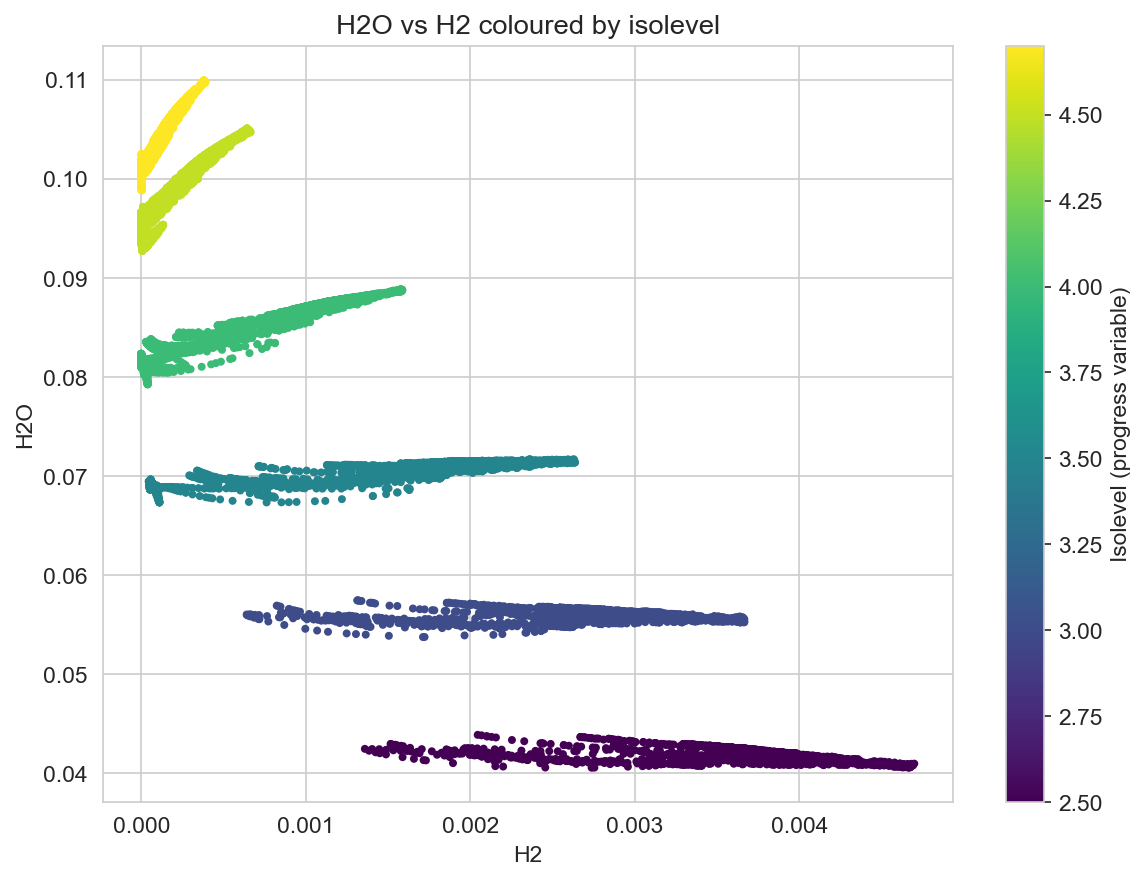

In [6]:
x_var = "H2"
y_var = "H2O"


iso_min = min(isolevels)
iso_max = max(isolevels)

cmap_iso = plt.get_cmap("viridis")

fig, ax = plt.subplots(figsize=(8, 6))

for c_val in isolevels:
    res = all_cluster_results[c_val]
    front = res["front"]

    # Colour by the actual isolevel c_val
    ax.scatter(
        front[x_var],
        front[y_var],
        c=np.full(len(front), c_val),
        cmap=cmap_iso,
        s=8,
        vmin=iso_min,
        vmax=iso_max,
    )

# ---------------------------------------
# Colorbar using REAL isolevel values
# ---------------------------------------
mappable = plt.cm.ScalarMappable(
    cmap=cmap_iso,
    norm=plt.Normalize(vmin=iso_min, vmax=iso_max)
)
mappable.set_array([])

cbar = fig.colorbar(mappable, ax=ax)
cbar.set_label("Isolevel (progress variable)")

ax.set_xlabel(x_var)
ax.set_ylabel(y_var)
ax.set_title(f"{y_var} vs {x_var} coloured by isolevel")

plt.tight_layout()
plt.show()


In [17]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def interactive_front_plotly(res, var_x="H2", var_y="H2O", c_val=None):
    """
    res: all_cluster_results[c_val], with keys:
         - "front": DataFrame with columns ["x", "y", var_x, var_y, ...]
         - "labels": cluster labels (array-like)

    Interaction:
        - Click/tap on the physical-space plot (left) OR the state-space plot (right).
        - The clicked point index is used (Plotly gives it directly).
        - The corresponding point is highlighted in both plots.
    """

    front  = res["front"]
    labels = np.asarray(res["labels"])

    x_arr  = front["x"].to_numpy()
    y_arr  = front["y"].to_numpy()
    Xv_arr = front[var_x].to_numpy()
    Yv_arr = front[var_y].to_numpy()

    # ---- create subplots ----
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=(
            f"Physical space (flame front){'' if c_val is None else f' (c = {c_val})'}",
            f"State space ({var_x} vs {var_y}){'' if c_val is None else f' (c = {c_val})'}"
        )
    )

    # ---- base scatter: physical space ----
    sc_phys = go.Scatter(
        x=x_arr,
        y=y_arr,
        mode="markers",
        marker=dict(
            color=labels,
            colorscale="Turbo",
            size=6,
            colorbar=dict(title="Cluster"),
            showscale=True
        ),
        name="Physical",
        hovertemplate="x=%{x:.4f}<br>y=%{y:.4f}<br>cluster=%{marker.color}<extra></extra>"
    )
    fig.add_trace(sc_phys, row=1, col=1)

    # ---- base scatter: state space ----
    sc_state = go.Scatter(
        x=Xv_arr,
        y=Yv_arr,
        mode="markers",
        marker=dict(
            color=labels,
            colorscale="Turbo",
            size=6,
            showscale=False  # colorbar already on the left
        ),
        name="State",
        hovertemplate=(
            f"{var_x}=%{{x:.4e}}<br>{var_y}=%{{y:.4e}}"
            "<br>cluster=%{marker.color}<extra></extra>"
        )
    )
    fig.add_trace(sc_state, row=1, col=2)

    # ---- highlight markers (initially first point) ----
    idx0 = 0
    sel_phys = go.Scatter(
        x=[x_arr[idx0]],
        y=[y_arr[idx0]],
        mode="markers",
        marker=dict(
            size=14,
            symbol="circle-open",
            line=dict(width=2),
        ),
        name="Selected (phys)",
        showlegend=False
    )
    sel_state = go.Scatter(
        x=[Xv_arr[idx0]],
        y=[Yv_arr[idx0]],
        mode="markers",
        marker=dict(
            size=14,
            symbol="circle-open",
            line=dict(width=2),
        ),
        name="Selected (state)",
        showlegend=False
    )
    fig.add_trace(sel_phys,  row=1, col=1)
    fig.add_trace(sel_state, row=1, col=2)

    # convert to FigureWidget to enable callbacks
    fig = go.FigureWidget(fig)

    # references to traces (order: phys, state, sel_phys, sel_state)
    tr_phys      = fig.data[0]
    tr_state     = fig.data[1]
    tr_sel_phys  = fig.data[2]
    tr_sel_state = fig.data[3]

    # ---- click callback (used for both plots) ----
    def update_selected(trace, points, selector):
        if not points.point_inds:
            return
        idx = int(points.point_inds[0])

        with fig.batch_update():
            tr_sel_phys.x  = [x_arr[idx]]
            tr_sel_phys.y  = [y_arr[idx]]
            tr_sel_state.x = [Xv_arr[idx]]
            tr_sel_state.y = [Yv_arr[idx]]

    # attach callback to BOTH traces
    tr_phys.on_click(update_selected)
    tr_state.on_click(update_selected)

    # ---- axes / layout ----
    fig.update_xaxes(title_text="x", row=1, col=1)
    fig.update_yaxes(title_text="y", row=1, col=1)

    fig.update_xaxes(title_text=var_x, row=1, col=2)
    fig.update_yaxes(title_text=var_y, row=1, col=2)

    fig.update_layout(
        height=500,
        width=1000,
        margin=dict(l=60, r=40, t=60, b=40)
    )

    return fig




In [18]:
c_val = isolevels[-1]
res   = all_cluster_results[c_val]

fig = interactive_front_plotly(
    res,
    var_x="H2",
    var_y="H2O",
    c_val=c_val
)
fig  # in a notebook, this will display the interactive widget


FigureWidget({
    'data': [{'hovertemplate': 'x=%{x:.4f}<br>y=%{y:.4f}<br>cluster=%{marker.color}<extra></extra>',
              'marker': {'color': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAEAAAABAAAAAQAAAAEAAAABAAAA'),
                                   'dtype': 'i4'},
                         'colorbar': {'title': {'text': 'Cluster'}},
                         'colorscale': [[0.0, '#30123b'], [0.07142857142857142,
                                        '#4145ab'], [0.14285714285714285,
                                        '#4675ed'], [0.21428571428571427,
                                        '#39a2fc'], [0.2857142857142857,
                                        '#1bcfd4'], [0.35714285714285715,
                                        '#24eca6'], [0.42857142857142855,
                                        '#61fc6c'], [0.5, '#a4fc3b'],
                                        [0.5714285714285714, '#d1e834'],
                                        [0.642857142857